# ODIR5k - Tests

In [1]:
import numpy as np
import pandas as pd
import os
import io
import itertools
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# visualization dependencies
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.graph_objects as go
import plotly.offline as pyo

from plotly.offline import iplot, plot
from plotly.offline import init_notebook_mode

import cufflinks as cf
import warnings

warnings.filterwarnings('ignore')
cf.go_offline()
cf.set_config_file(offline=False, world_readable=False)

sns.set(style='whitegrid', palette='muted',
       rc={'figure.figsize': (16, 16)})
plt.rcParams['figure.dpi'] = 120.0
# plt.rcParams['font.sans-serif'] = 'lato'

init_notebook_mode(connected=False)

In [2]:
NUM_EPOCHS = 150
BATCH_SIZE = 64
LR = 1e-4
IMG_SIZE = 256

In [3]:
import shutil

def clear_content(directory):
    for img in os.listdir(directory):
        file_path = os.path.join(directory, img)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as exc:
            raise("Failed to delete: %s %s" % (file_path, exc))

def configure_plotly_browser_state():
    import IPython
    display(IPython.core.display.HTML('''
        <script src="/static/component/requirejs/require.js"></script>
        <script>
            requirejs.config({
                path: {
                    base: '/static/base',
                    plotly: 'https://cdn.plot.ly/plotly.1.5.1.min.js?noext',
                },
            });
        </script>
    '''))

In [4]:
for dirname, subfolders, filenames in os.walk("../../assets/datasets/odir5k"):
    for subf in subfolders:
        print(os.path.join(dirname, subf))

../../assets/datasets/odir5k\ODIR-5K
../../assets/datasets/odir5k\preprocessed_images
../../assets/datasets/odir5k\ODIR-5K\ODIR-5K
../../assets/datasets/odir5k\ODIR-5K\ODIR-5K\Testing Images
../../assets/datasets/odir5k\ODIR-5K\ODIR-5K\Training Images


# Step 1: Load and Explore the Dataset

In [6]:
train_dir = "../../assets/datasets/odir5k\ODIR-5K\ODIR-5K\Training Images"
test_dir = "../../assets/datasets/odir5k\ODIR-5K\ODIR-5K\Testing Images"
prep_train = "preprocess_train"
annotations_path = "../../assets/datasets/odir5k/full_df.csv"
disc_path = "../../assets/datasets/odir5k/DiscardedImages.csv"
train_files = sorted(os.listdir(train_dir))
test_files = sorted(os.listdir(test_dir))

print("train: ", len(train_files))
print('test: ', len(test_files))

train:  7000
test:  1000


### Visualize Few Fundus Images

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


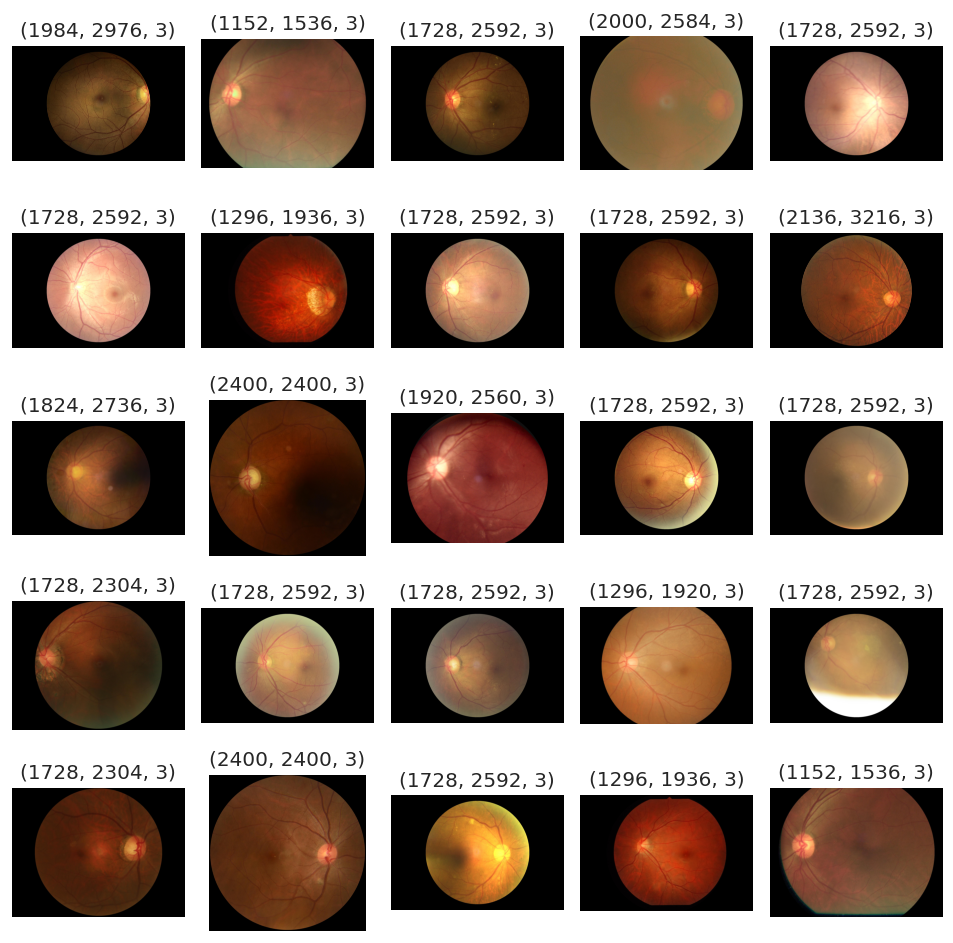

In [9]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0.1, hspace=0.2)

for i in range(25):
    rand_idx = np.random.randint(0, len(train_files))
    img_file = os.path.join(train_dir, train_files[rand_idx])
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(5, 5, i+1)
    plt.imshow(image)
    plt.title(f"{image.shape}")
    plt.axis('off')
    plt.grid(False)

plt.show()

### Exploratory Data Analysis

In [7]:
# pandas filtering functions

def data_mapping(df, initial):
    labels = []
    fundus_names = df.iloc[:, 3]
    
    for i in range(len(fundus_names)):
        labels.append(initial)
    return labels

def count_labels(df):
    labels = df.iloc[:, -12:-4].sum().index
    total_count = []
    labels_count = []
    
    for i in range(len(labels)):
        label_count = data_mapping(df.loc[(df[labels[i]] == 1)], labels[i])
        total_count += label_count
        labels_count.append(len(label_count))
        print(f"{labels[i]}: {len(label_count)}")
        
    return total_count, labels_count

In [8]:
annot_df = pd.read_csv(annotations_path)
annot_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [9]:
disc_sheet = pd.read_csv(disc_path)
disc_tokens = ["lens dust", "low image", "anterior", "optic disk", "refractive"]
annot_df = annot_df.loc[(~annot_df['Left-Fundus'].isin(disc_sheet['Left-Fundus']))]
annot_df = annot_df.loc[(~annot_df['Right-Fundus'].isin(disc_sheet['Right-Fundus']))]
annot_df = annot_df.loc[(~annot_df['Left-Diagnostic Keywords'].str.
                         contains("|".join(disc_tokens)))]
annot_df = annot_df.loc[(~annot_df['Right-Diagnostic Keywords'].str.
                         contains("|".join(disc_tokens)))]
print(len(annot_df.loc[(annot_df['Left-Diagnostic Keywords'].str.contains("|".join(disc_tokens)))]))
print(len(annot_df.loc[(annot_df['Left-Fundus'].isin(disc_sheet['Left-Fundus']))]))

0
0


In [10]:
total_count, labels_count = count_labels(annot_df)
print(len(total_count))

N: 2002
D: 2049
G: 365
C: 337
A: 310
H: 203
M: 278
O: 1395
6939


In [11]:
labels_ser = pd.Series(total_count, name='label')
labels_df = pd.DataFrame({
    'labels': labels_ser.value_counts().index,
    'count': labels_ser.value_counts()
})

label_counts = sorted(labels_count, reverse=True)
labels_df['percentage'] = [float(i / sum(label_counts)) for i in label_counts]
print(labels_df['percentage'])

fig = plt.figure(figsize=(16, 16))
fig = go.Figure(data=[go.Bar(
                x=labels_df['labels'],
                y=labels_df['count'],
                text=labels_df['percentage'].apply(lambda x: "{0:1.2f}%".format(x * 100)),
                textposition='auto',
                marker=dict(
                    colorscale='Viridis'
                )
                )])

fig.update_layout(
    title='Fundus Image Distribution',
    xaxis_title='disease',
    yaxis_title='count',
    font=dict(
        size=14
    )
)

fig.show()

D    0.295288
N    0.288514
O    0.201038
G    0.052601
C    0.048566
A    0.044675
M    0.040063
H    0.029255
Name: percentage, dtype: float64


<Figure size 1920x1920 with 0 Axes>

<AxesSubplot:ylabel='count'>

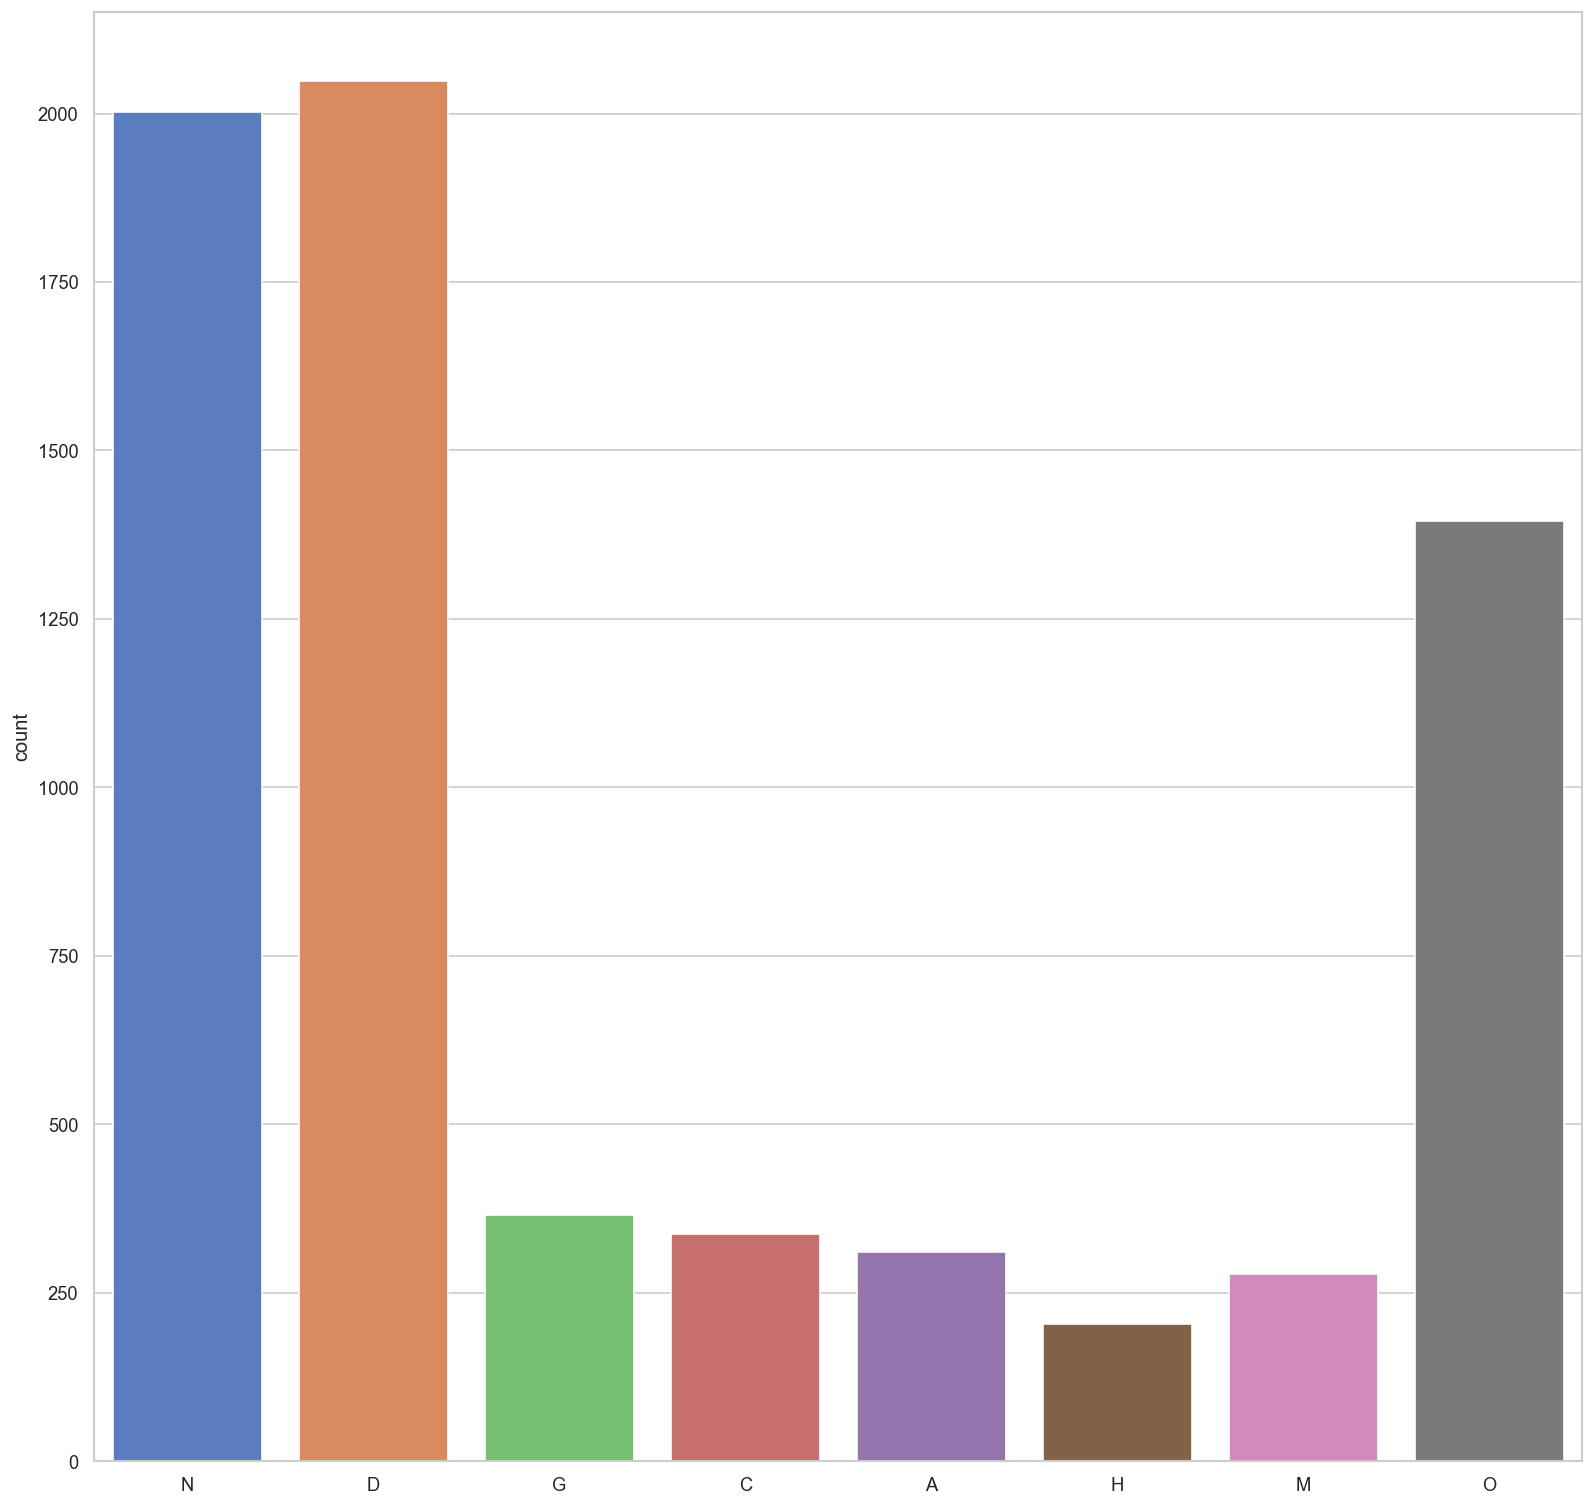

In [11]:
sns.countplot(total_count)

# Step 2: Data Preprocessing

**Crop Contour Method 1: Without Edge Detection** 

In [27]:
import imutils

def crop_contour_fundus_image(image, plot=False, image_size=(256, 256)):
    grayed = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    grayed = cv2.GaussianBlur(grayed, (5,5), 0)
#     thresh_image = cv2.threshold(grayed, 65, 255, cv2.THRES_BINARY)[1]
    thresh_image = cv2.erode(grayed, None, iterations=2)
    thresh_image = cv2.dilate(thresh_image, None, iterations=2)
    
    # find contours
    contours = cv2.findContours(thresh_image.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours,key = cv2.contourArea)
    
    # extract bounding coords from largest contour
    extreme_pnts_left = tuple(c[c[:, :, 0].argmin()][0])
    extreme_pnts_right = tuple(c[c[:, :, 0].argmax()][0])
    extreme_pnts_top = tuple(c[c[:, :, 1].argmin()][0])
    extreme_pnts_bot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop image 
    new_image = grayed[extreme_pnts_top[1]:extreme_pnts_bot[1], extreme_pnts_left[0]:extreme_pnts_right[0]]
    
    # apply adaptive equalization
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    equalized = clahe.apply(new_image)
    
    # apply image normalization 
    mask = np.zeros((256,256))
    normalized = cv2.normalize(equalized, mask, 0, 255, cv2.NORM_MINMAX)
    
    # resize image
    new_image = cv2.resize(normalized, image_size, interpolation=cv2.INTER_AREA)
    
    if plot:
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title(f"Original - {image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        # ----------------------- #
        
        plt.subplot(1,2,2)
        plt.imshow(new_image, cmap='gray', vmin=0, vmax=255)
        plt.title(f"Preprocessed - {new_image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        plt.show()
    return new_image

**Crop Contour Method 2: With Edge Detection**

In [20]:
def crop_contour_retinal_image(image, plot=False, image_size=(256, 256)):
    image = cv2.resize(image, None, fx=0.3, fy=0.3, interpolation=cv2.INTER_AREA)
    grayed = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    grayed = cv2.GaussianBlur(grayed, (5,5), 0)
    thresh_image = cv2.erode(grayed, None, iterations=2)
    thresh_image = cv2.dilate(thresh_image, None, iterations=2)
    
    # find canny edges
    edges = cv2.Canny(thresh_image, 20, 70)
    
    # find contours
    contours = cv2.findContours(edges.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)
    
    # extract bounding coords from largest contour
    extreme_pnts_left = tuple(c[c[:, :, 0].argmin()][0])
    extreme_pnts_right = tuple(c[c[:, :, 0].argmax()][0])
    extreme_pnts_top = tuple(c[c[:, :, 1].argmin()][0])
    extreme_pnts_bot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop image
    new_image = grayed[extreme_pnts_top[1]:extreme_pnts_bot[1], extreme_pnts_left[0]:extreme_pnts_right[0]]
    new_image = cv2.resize(new_image, image_size, interpolation=cv2.INTER_AREA)
    
    if plot:
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Original - {image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        # -------------------------------------------- #
        
        plt.subplot(1, 2, 2)
        plt.imshow(new_image, cmap='gray', vmin=0, vmax=255)
        plt.title(f"Preprocessed - {new_image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        plt.show()
        
    return new_image

**Method 3: Crop only and Resize Image**
* Leaves image as RGB

In [12]:
def crop_image(image, plot=False, image_size=(256, 256)):
    # mask of colored pixels
    mask = image > 0
    
    # coordinates of colored pixels
    coordinates = np.argwhere(mask)
    
    # binding box of non-black pixels
    x0, y0, s0 = coordinates.min(axis=0)
    x1, y1, s1 = coordinates.max(axis=0) + 1 # slices are exclusive at the top
    
    # get the contents of the bouding box
    cropped = image[x0:x1, y0:y1]
    
    # convert to COLOR_RGB2YUV for equalization
    img_yuv = cv2.cvtColor(cropped, cv2.COLOR_RGB2YUV)
    
    # apply adaptive equalization on colored image
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    img_yuv[:, :, 0] = clahe.apply(img_yuv[:, :, 0])
    
    # apply image normalization on colored image
    mask = np.zeros((256,256))
    normalized = cv2.normalize(img_yuv[:, :, 0], mask, 0, 255, cv2.NORM_MINMAX)
    
    new_image = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)
    
    new_image = cv2.resize(new_image, image_size, interpolation=cv2.INTER_AREA)
    
    # must convert back to BGR to have it saved as RGB
    # cv2 just swaps channels when loaded hence BGR when shown
    # only converted to RGB for visualization purposes
    # but will be converted to BGR again to be saved as RGB
    final_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    if plot:
        plt.subplot(1,2,1)
        plt.imshow(image)
        plt.title(f"Original - {image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        # ----------------------- #
        plt.subplot(1,2,2)
        plt.imshow(new_image)
        plt.title(f"Preprocessed - {new_image.shape}")
        plt.axis('off')
        plt.grid(False)
        
        plt.show()
        
    return final_image

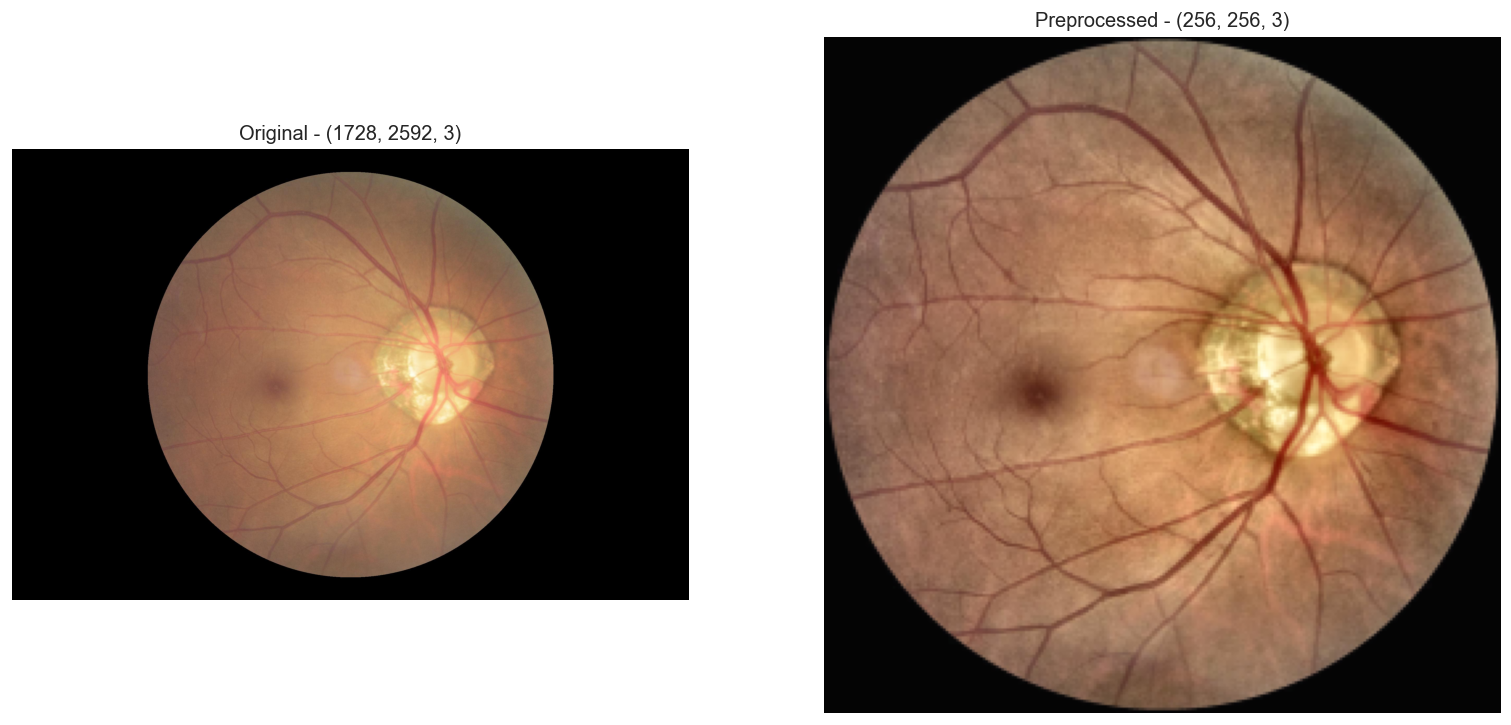

(256, 256, 3)


In [13]:
import traceback

try:
    rand_idx = np.random.randint(0, len(train_files))
    img_file = os.path.join(train_dir, train_files[rand_idx])
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     new_image = crop_contour_fundus_image(image, plot=True, image_size=(IMG_SIZE, IMG_SIZE))
    new_image = crop_image(image, plot=True, image_size=(IMG_SIZE, IMG_SIZE))
    print(new_image.shape)
except Exception as exc:
    traceback.print_tb(exc.__traceback__)

### Preprocess Train Images

In [62]:
train_output = "preprocess_train"

if os.path.isdir(train_output):
    clear_content(train_output)
else:
    os.mkdir(train_output)
    
train_prep_images = []

try:
    for img in os.listdir(train_dir):
        file_path = os.path.join(train_dir, img)
        if os.path.isfile(file_path):
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             new_image = crop_contour_fundus_image(image, plot=False, image_size=(IMG_SIZE, IMG_SIZE))
            new_image = crop_image(image, plot=False, image_size=(IMG_SIZE, IMG_SIZE))
            new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
            new_img_path = os.path.join(train_output, img)
            cv2.imwrite(new_img_path, new_image)
            train_prep_images.append(new_img_path)
            
except Exception as exc:
    traceback.print_tb(exc.__traceback__)
    
print("Train: ", len(train_prep_images))

Train:  7000


**Visualize Preprocessed Train Images**

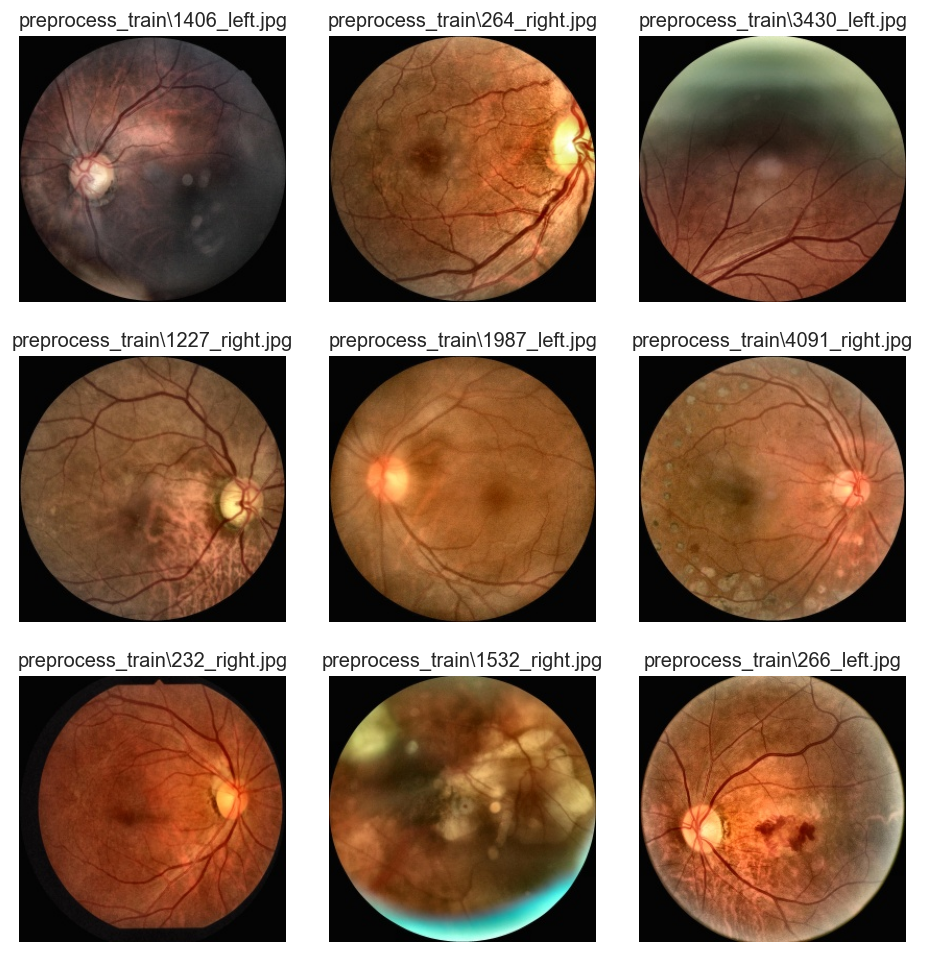

In [63]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0.2)

for i in range(9):
    rand_idx = np.random.randint(0, len(train_prep_images))
    img_file = train_prep_images[rand_idx]
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i+1)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.title(f"{img_file.split('/')[0]}")
    plt.axis('off')
    plt.grid(False)
    
plt.show()

### Preprocess Test

In [16]:
test_output = "preprocess_test"

if os.path.isdir(test_output):
    clear_content(test_output)
else:
    os.mkdir(test_output)
    
test_prep_images = []

try:
    for img in os.listdir(test_dir):
        file_path = os.path.join(test_dir, img)
        if os.path.isfile(file_path):
            image = cv2.imread(file_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             new_image = crop_contour_fundus_image(image, plot=False, image_size=(IMG_SIZE, IMG_SIZE))
            new_image = crop_image(image, plot=False, image_size=(IMG_SIZE, IMG_SIZE))
#             new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
            new_img_path = os.path.join(test_output, img)
            cv2.imwrite(new_img_path, new_image)
            test_prep_images.append(new_img_path)
            
except Exception as exc:
    traceback.print_tb(exc.__traceback__)
    
print("Test: ", len(test_prep_images))

Test:  1000


**Visualize Preprocessed Test**

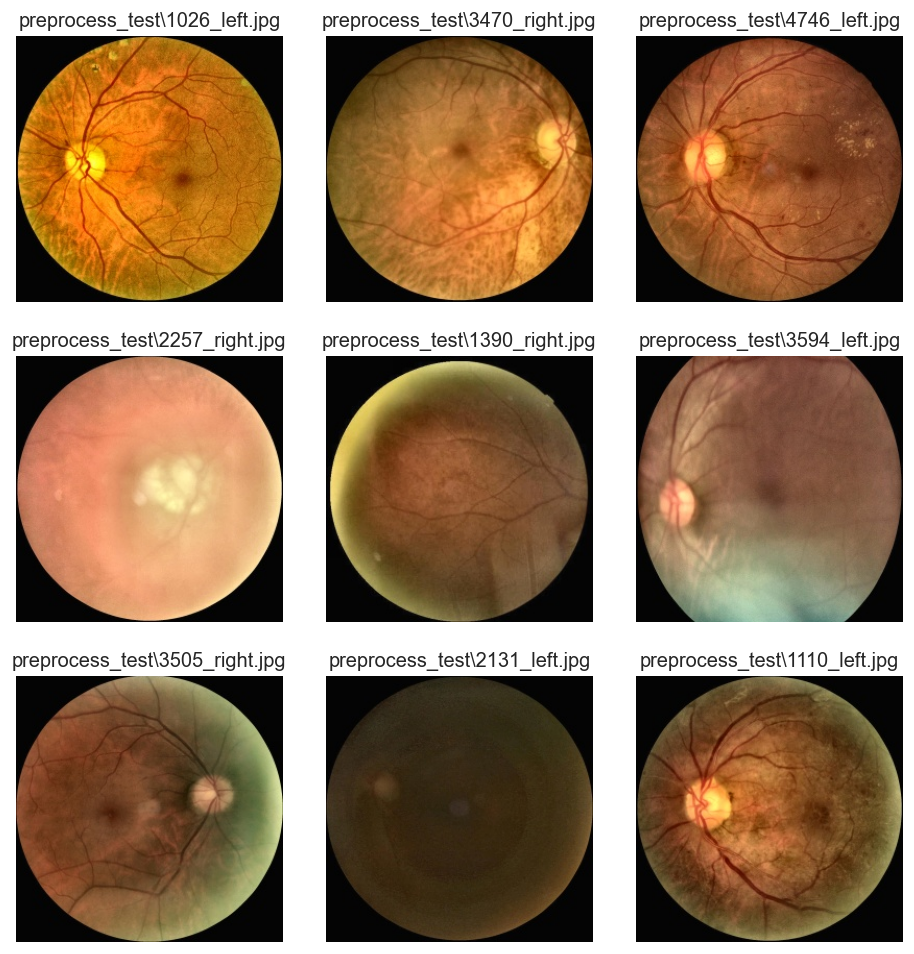

In [17]:
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0.2)

for i in range(9):
    rand_idx = np.random.randint(0, len(test_prep_images))
    img_file = test_prep_images[rand_idx]
    image = cv2.imread(img_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i+1)
    plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    plt.title(f"{img_file.split('/')[0]}")
    plt.axis('off')
    plt.grid(False)
    
plt.show()

# Step 3: Data Mapping
* The funduscopic images are not annotated with labels and put in separate folders, thus annotations will have to be done and images will have to be mapped to their respective classes. Luckily, a full information sheet on the retinal images is provided, this can be easily accomplished with Pandas DataFrames.

In [18]:
# drop unnecessary columns
df_slim = annot_df.iloc[:, 1:15]
df_slim.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6019 entries, 0 to 6391
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Patient Age                6019 non-null   int64 
 1   Patient Sex                6019 non-null   object
 2   Left-Fundus                6019 non-null   object
 3   Right-Fundus               6019 non-null   object
 4   Left-Diagnostic Keywords   6019 non-null   object
 5   Right-Diagnostic Keywords  6019 non-null   object
 6   N                          6019 non-null   int64 
 7   D                          6019 non-null   int64 
 8   G                          6019 non-null   int64 
 9   C                          6019 non-null   int64 
 10  A                          6019 non-null   int64 
 11  H                          6019 non-null   int64 
 12  M                          6019 non-null   int64 
 13  O                          6019 non-null   int64 
dtypes: int64

### Extract Fundus Images per Disease
The diseases are:
* Normal (N)
* Diabetes (D)
* Glaucoma (G)
* Cataract (C)
* Age related Macular Degeneration (A)
* Hypertension (H)
* Pathological Myopia (M)
* Other diseases/abnormalities (O)

In [19]:
# extract normal images
df_left_norm = df_slim.loc[(df_slim['Left-Diagnostic Keywords'].str.contains('normal fundus'))]
df_right_norm = df_slim.loc[(df_slim['Right-Diagnostic Keywords'].str.contains('normal fundus'))]

# combine left and right norms
df_norm = df_left_norm['Left-Fundus'].append(df_right_norm['Right-Fundus'], ignore_index=True)
print("normal: ", len(df_norm))

# tests
# df_slim.loc[(df_slim['Right-Diagnostic Keywords'].str.contains('normal')), 'Right-Diagnostic Keywords']

normal:  5389


In [20]:
# extrat diabetes images
df_left_diabetes = df_slim.loc[(df_slim['Left-Diagnostic Keywords']
                            .str.contains('|'.join(["diabetic", "proliferative"])))]
df_right_diabetes = df_slim.loc[(df_slim['Right-Diagnostic Keywords']
                                .str.contains('|'.join(["diabetic", "proliferative"])))]

# combine left and right diabetes
df_diabetes = df_left_diabetes['Left-Fundus'].append(df_right_diabetes['Right-Fundus'], ignore_index=True)
print("diabetes: ", len(df_diabetes))

# tests
# df_slim.loc[(df_slim['Left-Diagnostic Keywords']
#              .str.contains('proliferative')), 'Left-Diagnostic Keywords']
# df_slim.loc[(df_slim['Left-Diagnostic Keywords']
#              .str.contains('|'.join(['diabetes', 'proliferative']))), 'Left-Diagnostic Keywords']

diabetes:  3323


In [21]:
# extract glaucoma images
df_left_glaucoma = df_slim.loc[(df_slim['Left-Diagnostic Keywords'].str.contains('glaucoma'))]
df_right_glaucoma = df_slim.loc[(df_slim['Right-Diagnostic Keywords'].str.contains('glaucoma'))]

# combine glaucoma
df_glaucoma = df_left_glaucoma['Left-Fundus'].append(df_right_glaucoma['Right-Fundus'], ignore_index=True)
print("glaucoma: ", len(df_glaucoma))

glaucoma:  582


In [22]:
# extract cataract images
df_left_cat = df_slim.loc[(df_slim['Left-Diagnostic Keywords'].str.contains('cataract'))]
df_right_cat = df_slim.loc[(df_slim['Right-Diagnostic Keywords'].str.contains('cataract'))]

# combine cataract images
df_cataract = df_left_cat['Left-Fundus'].append(df_right_cat['Right-Fundus'], ignore_index=True)
print("cataract: ", len(df_cataract))

cataract:  506


In [23]:
# extract age-related macular degeneration
df_left_amd = df_slim.loc[(df_slim['Left-Diagnostic Keywords'].str.contains('age-related'))]
df_right_amd = df_slim.loc[(df_slim['Right-Diagnostic Keywords'].str.contains('age-related'))]

# combine AMD images
df_amd = df_left_amd['Left-Fundus'].append(df_right_amd['Right-Fundus'], ignore_index=True)
print("amd: ", len(df_amd))

amd:  542


In [24]:
# extract hypertension
df_left_hypertension = df_slim.loc[(df_slim['Left-Diagnostic Keywords'].str.contains('hypertensive'))]
df_right_hypertension = df_slim.loc[(df_slim['Right-Diagnostic Keywords'].str.contains('hypertensive'))]

# combine hypertension images
df_hypertension = df_left_hypertension['Left-Fundus'].append(df_right_hypertension['Right-Fundus'], ignore_index=True)
print("hypertension: ", len(df_hypertension))

hypertension:  382


* Found few images classified as **Vitreous Degeneration**, so to check if it's classified also as AMD, we have to check the annotations sheet.

In [25]:
# check if vitreous degeneration is classified also as AMD
df_slim.loc[(df_slim['Left-Diagnostic Keywords'].str.contains('vitreous'))].head(5)

Patient Age Patient Sex   Left-Fundus   Right-Fundus  \
79            56      Female   96_left.jpg   96_right.jpg   
96            66      Female  115_left.jpg  115_right.jpg   
125           70      Female  148_left.jpg  148_right.jpg   
144           59        Male  170_left.jpg  170_right.jpg   
145           68        Male  172_left.jpg  172_right.jpg   

    Left-Diagnostic Keywords               Right-Diagnostic Keywords  N  D  G  \
79     vitreous degeneration  moderate non proliferative retinopathy  0  1  0   
96     vitreous degeneration                           normal fundus  0  0  0   
125    vitreous degeneration  moderate non proliferative retinopathy  0  1  0   
144    vitreous degeneration                           normal fundus  0  0  0   
145    vitreous degeneration                           normal fundus  0  0  0   

     C  A  H  M  O  
79   0  0  0  0  1  
96   0  0  0  0  1  
125  0  0  0  0  1  
144  0  0  0  0  1  
145  0  0  0  0  1

* It's classified as **Other Disease** thus it will not be included in the AMD images

In [26]:
# extract myopia images
df_left_myopia = df_slim.loc[(df_slim['Left-Diagnostic Keywords'].str.contains('pathological myopia'))]
df_right_myopia = df_slim.loc[(df_slim['Right-Diagnostic Keywords'].str.contains('pathological myopia'))]

# combine myopia images
df_myopia = df_left_myopia['Left-Fundus'].append(df_right_myopia['Right-Fundus'], ignore_index=True)
print("myopia: ", len(df_myopia))

myopia:  417


### Extract Others
* There are around 25 other diseases, manually going through each one to concatenate after will take forever, thus we will just use the already recognized 7 diseases above for cross-referencing to the other diseases and classify them in one whole class **Other Diseases/Abnormalities**

In [27]:
df_slim.loc[(df_slim['O'] == 1)].head(5)
# initially we used class O to get the other diseases but doing this 
# will only get you the classified-only-once diseases as "Other" not those
# with multiple diseases including non-other and other.

Patient Age Patient Sex Left-Fundus Right-Fundus  \
2           42        Male  2_left.jpg  2_right.jpg   
3           53        Male  4_left.jpg  4_right.jpg   
5           60        Male  6_left.jpg  6_right.jpg   
6           60      Female  7_left.jpg  7_right.jpg   
8           54        Male  9_left.jpg  9_right.jpg   

                            Left-Diagnostic Keywords  \
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
5                        macular epiretinal membrane   
6                                             drusen   
8                                      normal fundus   

                           Right-Diagnostic Keywords  N  D  G  C  A  H  M  O  
2             moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  
3                  mild nonproliferative retinopathy  0  1  0  0  0  0  0  1  
5  moderate non proliferative retinopathy，epireti...  0  1  0  0  0  0  0  1  
6                  mild nonproliferative retinopathy  0  1  0  0  0  0  0  1  
8                              vitreous degeneration  0  0  0  0  0  0  0  1

In [28]:
annot_df.iloc[:, -12:-4].sum()

N    2002
D    2049
G     365
C     337
A     310
H     203
M     278
O    1395
dtype: int64

33

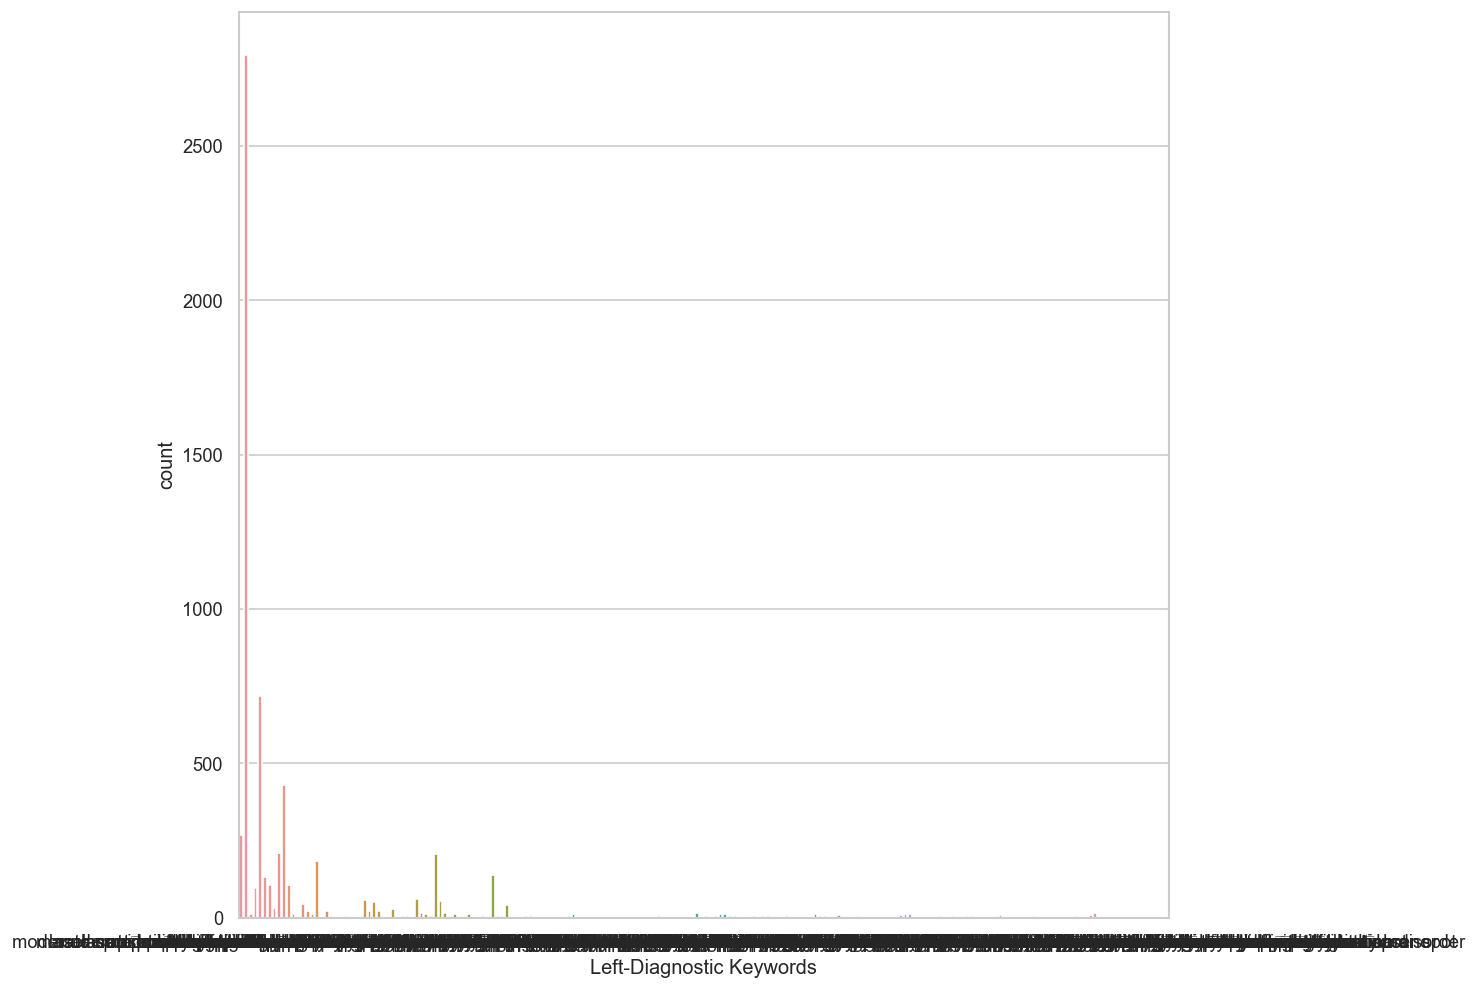

In [59]:
pd.set_option('display.max_rows', None)
sns.countplot(x='Left-Diagnostic Keywords', data=df_slim)
len(df_slim['Left-Diagnostic Keywords'].value_counts().unique())

In [29]:
# df_slim.loc[(~df_slim['Right-Diagnostic Keywords'].str.contains('normal') & df_slim['O'] == 1), 'Right-Diagnostic Keywords']

common_diseases = ["myopia", "normal fundus", "cataract", "glaucoma", \
                   "hypertensive", "proliferative", "age-related", "diabetic"]
df_slim.loc[~df_slim['Left-Diagnostic Keywords'].str.contains('|'.join(common_diseases)), 'Left-Diagnostic Keywords']

3       macular epiretinal membrane
5       macular epiretinal membrane
6                            drusen
9               epiretinal membrane
15                           drusen
                   ...             
4260                         drusen
4263            epiretinal membrane
4334            epiretinal membrane
4469            epiretinal membrane
4521                         drusen
Name: Left-Diagnostic Keywords, Length: 572, dtype: object

In [30]:
# extract others
df_left_others = df_slim.loc[(~df_slim['Left-Diagnostic Keywords']
                              .str.contains('|'.join(common_diseases)))]

df_right_others = df_slim.loc[(~df_slim['Right-Diagnostic Keywords']
                              .str.contains('|'.join(common_diseases)))]

# combine others
df_others = df_left_others['Left-Fundus'].append(df_right_others['Right-Fundus'], ignore_index=True)
print("others: ", len(df_others))

others:  1217


In [31]:
annot_df.isna().sum()

ID                           0
Patient Age                  0
Patient Sex                  0
Left-Fundus                  0
Right-Fundus                 0
Left-Diagnostic Keywords     0
Right-Diagnostic Keywords    0
N                            0
D                            0
G                            0
C                            0
A                            0
H                            0
M                            0
O                            0
filepath                     0
labels                       0
target                       0
filename                     0
dtype: int64

In [32]:
# count labels

def extract_labels(df, initial):
    labels = []
    fundus_names = df.iloc[:]
    
    for i in range(len(fundus_names)):
        labels.append(initial)
        
    return labels

### Visualize Class Distribution (after data mapping)

In [33]:
total_count_labels = []
labels_each_count = []

labels_normal = extract_labels(df_norm, "N")
labels_diabetes = extract_labels(df_diabetes, "D")
labels_glaucoma = extract_labels(df_glaucoma, "G")
labels_cataract = extract_labels(df_cataract, "C")
labels_amd = extract_labels(df_amd, "A")
labels_hypertension = extract_labels(df_hypertension, "H")
labels_myopia = extract_labels(df_myopia, "M")
labels_others = extract_labels(df_others, "O")

total_count_labels += labels_normal
total_count_labels += labels_diabetes 
total_count_labels += labels_glaucoma
total_count_labels += labels_cataract
total_count_labels += labels_amd
total_count_labels += labels_hypertension
total_count_labels += labels_myopia
total_count_labels += labels_others

labels_each_count.append(len(labels_normal))
labels_each_count.append(len(labels_diabetes))
labels_each_count.append(len(labels_glaucoma))
labels_each_count.append(len(labels_cataract))
labels_each_count.append(len(labels_amd))
labels_each_count.append(len(labels_hypertension))
labels_each_count.append(len(labels_myopia))
labels_each_count.append(len(labels_others))

print("Total Count: ", len(total_count_labels))
labels_each_count

Total Count:  12358


[5389, 3323, 582, 506, 542, 382, 417, 1217]

In [34]:
labels_series = pd.Series(total_count_labels, name='label')
labels_dframe = pd.DataFrame({
    'labels': labels_series.value_counts().index,
    'count': labels_series.value_counts()
})

label_count = sorted(labels_each_count, reverse=True)
labels_dframe['percentage'] = [float(i / sum(label_count)) for i in label_count]

fig = plt.figure(figsize=(16, 16))
fig = go.Figure(data=[go.Bar(
                x=labels_dframe['labels'],
                y=labels_dframe['count'],
                text=labels_dframe['percentage'].apply(lambda x: "{0:1.2f}%".format(x * 100)),
                textposition='auto',
                marker=dict(
                    colorscale='Viridis'
                )
                )])

fig.update_layout(
    title='Fundus Image Distribution',
    xaxis_title='disease',
    yaxis_title='count',
    font=dict(
        size=13
    )
)

fig.show()

<Figure size 1920x1920 with 0 Axes>

* The distribution is heavily imbalanced, we might have to downsample the major classes.

### Downsample Major Classes

In [38]:
df_normal_dn = df_norm.sample(n=700).reset_index(drop=True)
df_diabetes_dn = df_diabetes.sample(n=664).reset_index(drop=True)
df_others_dn = df_others.sample(n=604).reset_index(drop=True)

In [39]:
total_count_labels = []
labels_each_count = []

labels_normal = extract_labels(df_normal_dn, "N")
labels_diabetes = extract_labels(df_diabetes_dn, "D")
labels_glaucoma = extract_labels(df_glaucoma, "G")
labels_cataract = extract_labels(df_cataract, "C")
labels_amd = extract_labels(df_amd, "A")
labels_hypertension = extract_labels(df_hypertension, "H")
labels_myopia = extract_labels(df_myopia, "M")
labels_others = extract_labels(df_others_dn, "O")

total_count_labels += labels_normal
total_count_labels += labels_diabetes 
total_count_labels += labels_glaucoma
total_count_labels += labels_cataract
total_count_labels += labels_amd
total_count_labels += labels_hypertension
total_count_labels += labels_myopia
total_count_labels += labels_others

labels_each_count.append(len(labels_normal))
labels_each_count.append(len(labels_diabetes))
labels_each_count.append(len(labels_glaucoma))
labels_each_count.append(len(labels_cataract))
labels_each_count.append(len(labels_amd))
labels_each_count.append(len(labels_hypertension))
labels_each_count.append(len(labels_myopia))
labels_each_count.append(len(labels_others))

print("Total Count: ", len(total_count_labels))
labels_each_count

Total Count:  4397


[700, 664, 582, 506, 542, 382, 417, 604]

In [40]:
labels_ser = pd.Series(total_count_labels, name='label')
labels_df = pd.DataFrame({
    'labels': labels_ser.value_counts().index,
    'count': labels_ser.value_counts()
})

label_count = sorted(labels_each_count, reverse=True)
labels_df['percentage'] = [float(i / sum(label_count)) for i in label_count]

fig = plt.figure(figsize=(16, 16))
fig = go.Figure(data=[go.Bar(
                x=labels_df['labels'],
                y=labels_df['count'],
                text=labels_df['percentage'].apply(lambda x: "{0:1.2f}%".format(x * 100)),
                textposition='auto',
                marker=dict(
                    colorscale='Viridis'
                )
                )])

fig.update_layout(
    title='Fundus Image Distribution',
    xaxis_title='disease',
    yaxis_title='count',
    font=dict(
        size=13
    )
)

fig.show()

<Figure size 1920x1920 with 0 Axes>

### Add Labels in Each Dataframe

In [41]:
# add labels in normal
dframe_normal = pd.DataFrame(df_normal_dn, columns=['filename'])
dframe_normal['disease'] = 'normal'
dframe_normal.head(5)

filename disease
0   3337_left.jpg  normal
1   883_right.jpg  normal
2   2769_left.jpg  normal
3  3390_right.jpg  normal
4   3026_left.jpg  normal

In [42]:
# add labels in diabetes 
dframe_diabetes = pd.DataFrame(df_diabetes_dn, columns=['filename'])
dframe_diabetes['disease'] = 'diabetes'
dframe_diabetes.head(5)

filename   disease
0   4113_left.jpg  diabetes
1  4443_right.jpg  diabetes
2   4116_left.jpg  diabetes
3  1113_right.jpg  diabetes
4  4631_right.jpg  diabetes

In [43]:
# add labels in glaucoma
dframe_glaucoma = pd.DataFrame(df_glaucoma, columns=['filename'])
dframe_glaucoma['disease'] = 'glaucoma'
dframe_glaucoma.head(5)

filename   disease
0   95_left.jpg  glaucoma
1  153_left.jpg  glaucoma
2  167_left.jpg  glaucoma
3  178_left.jpg  glaucoma
4  247_left.jpg  glaucoma

In [44]:
# add labels in cataract
dframe_cataract = pd.DataFrame(df_cataract, columns=['filename'])
dframe_cataract['disease'] = 'cataract'
dframe_cataract.head(5)

filename   disease
0    0_left.jpg  cataract
1   81_left.jpg  cataract
2  103_left.jpg  cataract
3  119_left.jpg  cataract
4  254_left.jpg  cataract

In [45]:
# add labels in amd
dframe_amd = pd.DataFrame(df_amd, columns=['filename'])
dframe_amd['disease'] = 'age-related macular degeneration'
dframe_amd.head(5)

filename                           disease
0   43_left.jpg  age-related macular degeneration
1   48_left.jpg  age-related macular degeneration
2   53_left.jpg  age-related macular degeneration
3   55_left.jpg  age-related macular degeneration
4  102_left.jpg  age-related macular degeneration

In [46]:
# add labels in hypertension
dframe_hypertension = pd.DataFrame(df_hypertension, columns=['filename'])
dframe_hypertension['disease'] = 'hypertension'
dframe_hypertension.head(5)

filename       disease
0  11_left.jpg  hypertension
1  23_left.jpg  hypertension
2  28_left.jpg  hypertension
3  32_left.jpg  hypertension
4  45_left.jpg  hypertension

In [47]:
# add labels to myopia
dframe_myopia = pd.DataFrame(df_myopia, columns=['filename'])
dframe_myopia['disease'] = 'pathological myopia'
dframe_myopia.head(5)

filename              disease
0   13_left.jpg  pathological myopia
1   18_left.jpg  pathological myopia
2   35_left.jpg  pathological myopia
3  106_left.jpg  pathological myopia
4  144_left.jpg  pathological myopia

In [48]:
# add labels in others
dframe_others = pd.DataFrame(df_others_dn, columns=['filename'])
dframe_others['disease'] = 'rare disease'
dframe_others.head(5)

filename       disease
0  356_right.jpg  rare disease
1   596_left.jpg  rare disease
2   200_left.jpg  rare disease
3   728_left.jpg  rare disease
4   312_left.jpg  rare disease

### Combine All Cases

In [49]:
df_combined = pd.concat([dframe_normal, dframe_diabetes, dframe_glaucoma, dframe_cataract, \
                        dframe_amd, dframe_hypertension, dframe_myopia, dframe_others])
df_combined.head(5)

filename disease
0   3337_left.jpg  normal
1   883_right.jpg  normal
2   2769_left.jpg  normal
3  3390_right.jpg  normal
4   3026_left.jpg  normal

In [50]:
df_combined.tail()

filename       disease
599   828_right.jpg  rare disease
600   986_right.jpg  rare disease
601  1021_right.jpg  rare disease
602   524_right.jpg  rare disease
603    805_left.jpg  rare disease

In [51]:
len(df_combined)

4397

### Randomize Data
We will randomize our concatenated dataframe then reset its indices by dropping its previous indices and allow pandas to create incremental indices.

In [52]:
df_combined_rand = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_rand.head()

filename       disease
0   2004_left.jpg  hypertension
1   2631_left.jpg        normal
2   1493_left.jpg      glaucoma
3  1374_right.jpg      glaucoma
4    809_left.jpg      cataract

# Step 4: Data Augmentation

### Split Dataframe into Train, Test and Validation
Since we're going to continue to use a dataframe with a labels column, we can't use the usual sklean train_test_split function. We will instead simplify things and create dataframes by pulling random samples out and then excluding those samples from another set by using drop method.

In [53]:
# pull 80% train data from the concatenated dataframe
# the 20% will be for test data
# the ImageDataGeerator we will use later, will be the one to split
# a validation from the train data

df_train = df_combined_rand.sample(frac=0.8, random_state=42)
df_train.reset_index(drop=True)

# 20% for testing
df_test = df_combined_rand.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_rand))
print(len(df_train))
print(len(df_test))

4397
3518
879


In [54]:
# different augmentation techniques are used for data variability

train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.20,
    width_shift_range=0.12,
    height_shift_range=0.12,
    rotation_range=90,
    shear_range=5,
    horizontal_flip=True,
    vertical_flip=True,
#     zoom_range=[0.2, 0.3],
    brightness_range=(0.1, 1.6),
    channel_shift_range=30.0,
    fill_mode='nearest'
)

# no augmentation is needed for test data
test_datagen = ImageDataGenerator(rescale=1./255)

In [56]:
train_output = "preprocess_train"
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_output,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    x_col='filename',
    y_col='disease',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    subset='training'
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df_train,
    directory=train_output,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    x_col='filename',
    y_col='disease',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=train_output,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    x_col='filename',
    y_col='disease',
    batch_size=BATCH_SIZE,
#     seed=42,
    shuffle=False,
    class_mode='categorical'
)

Found 2802 validated image filenames belonging to 8 classes.
Found 700 validated image filenames belonging to 8 classes.
Found 876 validated image filenames belonging to 8 classes.
